# Training PyTorch Models using Horovod with Open MPI

## Background

Horovod is a distributed deep learning training framework that is used to speed up deep learning workloads. This notebook will show you how to train your PyTorch models using Horovod with Open MPI. Using the Sagemaker Python SDK, we will:

* Upload a data set to S3
* Train a simple neural network with Horovod
* Deploy a model to a SageMaker endpoint

You can learn more about Horovod and MPI at the following links:

* https://horovod.readthedocs.io/en/stable/pytorch.html
* https://horovod.readthedocs.io/en/stable/mpirun.html 


## Setup

For this example, we'll use the MNIST data set. MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits).

### Downloading the Data

The MNIST data set is easily accessible through the `torchvision.datasets` package. Note that even though we've set `train=false`, the code downloads both the training and testing data.

In [25]:
import torch
import torchvision

dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

### Previewing the Data

Let's preview what the input images look like. We can do this using `matplotlib`.

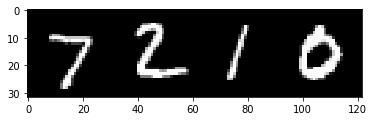

In [26]:
import matplotlib.pyplot as plt

dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
images, labels = next(iter(dataloader))
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.permute(1, 2, 0))  
plt.show()

### Uploading the Data

We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

To upload our data to S3, we need to specify an S3 bucket and prefix. These should be within the same region as the Notebook Instance, training, and hosting.

In [27]:
import sagemaker
from sagemaker.s3 import S3Uploader

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = 'pytorch-horovod-mpi-example'
inputs = S3Uploader.upload('data', 's3://{}/{}/data'.format(bucket, prefix))

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


## Training

In order to use Horovod with OpenMPI, we'll have to use a shell script as the training entry point. The shell script invoke our Python training script as part of an Open MPI command.

Here's what the shell script looks like:

In [28]:
!cat src/train.sh

mpirun -np 8 \
    -bind-to none -map-by slot \
    -x NCCL_DEBUG=INFO -x LD_LIBRARY_PATH -x PATH \
    -mca pml ob1 -mca btl ^openib \
    python train.py

As for the actual training script, here's what we're using:

In [29]:
!pygmentize src/train.py

"""Functions for training a simple neural network."""
import argparse
import os

import torch
import torch.multiprocessing as mp
from torchvision import transforms, datasets
import horovod.torch as hvd

from model import Net


def main(args):
    """Main program."""
    if not torch.cuda.is_available():
        raise RuntimeError("Expected CUDA-capable device but found none.")

    init(args.seed)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset = datasets.MNIST(
        root=args.data_dir,
        train=True,
        transform=transform)

    model = Net().to("cuda")

    train(model,
          dataset,
          batch_size=args.batch_size,
          num_epochs=args.epochs,
          momentum=args.momentum,
          learning_rate=args.lr)

    save(model, args.model_dir)


def init(seed):
    """Initialize Horovod and PyTorch for distributed training."""
    hvd.init()
    torch.manual_seed(seed

Notice how it's not any different than a training script you might write outside of SageMaker.

The IAM role arn is used to give training and hosting access to your data. See the Amazon SageMaker Roles for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with the appropriate full IAM role arn string(s).

In [30]:
from sagemaker.pytorch import PyTorch
role = sagemaker.get_execution_role()

The `PyTorch` class allows us to run our training script as a job on SageMaker. We need to configure it with our training script, an IAM role, the number and type of training instances, and hyperparameters. In this case we are going to run our training job on a ml.p8.xlarge instance, which contains eight Tesla K80 GPUs.

In [31]:
estimator = PyTorch(entry_point='train.sh',
                    source_dir="src",
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.8xlarge',
                    hyperparameters={'epochs': 6})

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to S3. 

In [32]:
estimator.fit(inputs)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-06-16 01:33:53 Starting - Starting the training job...
2020-06-16 01:33:56 Starting - Launching requested ML instances.........
2020-06-16 01:35:36 Starting - Preparing the instances for training.........
2020-06-16 01:37:01 Downloading - Downloading input data...
2020-06-16 01:37:30 Training - Downloading the training image......
2020-06-16 01:38:44 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-06-16 01:38:45,354 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-06-16 01:38:45,430 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-06-16 01:38:45,437 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-06-16 01:38:45,731 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020

## Hosting

### Creating an Endpoint

After training, we need to use the `PyTorch` estimator object to create a `PyTorchModel` object and set a different `entry_point`, otherwise, the training script `train.py` will be used for inference. (Note that the new `entry_point` must be under the same `source_dir` as `train.py`). Then we use the `PyTorchModel` object to deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference.

An implementation of `model_fn` is required for inference script. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-training-toolkit).

Here's the inference script we're using:

In [ ]:
!pygmentize src/inference.py

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. Here we will deploy the model to a single ml.c5.xlarge instance.

In [ ]:
# Create a PyTorchModel object with a different entry_point
model = estimator.create_model(entry_point="inference.py", source_dir="src")
# Deploy the model to a ml.c5.xlarge instance
predictor = model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

### Classify Digits

We can now use this predictor to classify hand-written digits. We'll try to predict the images we displayed earlier.

In [ ]:
import numpy as np

outputs = predictor.predict(images)
predictions = np.argmax(outputs, axis=1)

print('Predictions:', ' '.join('%4s' % predictions[i] for i in range(4)))

As expected, our model correctly classifies the digits.

## Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it!

In [ ]:
predictor.delete_endpoint()